## Try: Replicate (much of) a Publication With PalmettoBUG

Paper: https://doi.org/10.1016/j.cmet.2018.11.014 
("A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry". Damond N, Engler S, Zanotelli VRT, Schapiro D, Wasserfall CH, Kusmartseva I, Nick HS, Thorel F, Herrera PL, Atkinson MA and Bodenmiller B. Cell Metab. 2019 Mar 5;29(3):755-768.e5.)

Data source:

Download (images, metadata -- likely update all to version 2 before finalizing!): https://data.mendeley.com/datasets/cydmwsfztj/1

Download (masks, panel, 100 images subset): https://data.mendeley.com/datasets/cydmwsfztj/2     (version 2)

Data License: CC-BY 4.0 ( https://creativecommons.org/licenses/by/4.0/ ). Obviously the data was modified by its preparation for analysis & the analysis itself in PalmettoBUG.

The data requires some shaping / renaming and placing into folders to get them ready for analysis by PalmettoBUG

Notes:

    -- I am currently not working with the entirety of the dataset, only a subset.

    -- The example data's panel / metadata is not set up in a PalmettoBUG-friendly way, so I will need to set that up

    -- This publication does things that are difficult or at currently impossible in PalmettoBUG's GUI
    
        - ex: pseudo-time analysis (not possible in GUI), bounding boxes on individual pancreatic islets (difficult), cell densities
    
    -- I plan on doing this inside jupyter-lab notebooks, which will make some of the impossible steps possible and also precise replication of the steps that I take. However, I will also plan to test certain steps in the GUI to ensure that it is working as well

    -- I am not familiar with diabetes research, I will copy useful biological information from paper's text and methods here: 
           - Beta-cell markers = INS, PIN, IAPP, PTPRN ('markers' ), and PDX1, NKX6-1 ('transcription factors')

           - cell typing markers (use all mentioned in FlowSOM classification method):
                - islet vs. immune vs. exocrine vs. other --> CD99, SYP, AMY2A, KRT19, CD44, CD45, CDH, CD3, CD4, CD8, CD20, MPO, CD68, SMA

                - islet cell subtypes (alpha, beta, gamma, delta) --> INS, PIN, GCG, SST, PPY, PDX1, NKX6-1, IAPP, PCKS2, CD99, SYP

                - immune cells:
                     effector CD8 T cells: 'Tc' -- CD3, CD8, (CD45RA negative)
                     naive CD8 T cells: 'naive Tc' -- CD3, CD8, CD45RA
                     CD4 T cells: 'Th' -- CD3, CD4
                     B cells -- CD20
                     monocytes and macrophages: 'Mphi' -- CD45, CD68
                     neutrophils: 'Neutr' -- MPO
                     'other': CD45 or CD45RA but not in the categories above

                 - exocrine (acinar, ductal) --> KRT19, AMY2A, CD44, CDH

                 - other (endothelial, stroma, unknown) --> SMA, CD31, CD68, CDH

            - islet / blood vessel segmenation markers: SYP, CD99, CD31, CD45, AMY2A, KRT19, Iridum intercalator
                 

In [1]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
start_timer = time.time()

import palmettobug
print(time.time() - start_timer)  ## keep track of time after each major step -- 
                                  ## these numbers will only really matter on the FINAL run once everything is setup and the notebook is run sequentially. 

The PalmettoBUG package is copyrighted 2024-2025 by the Medical University of South Carolina and licensed under the GPL-3 license.
It is free & open source software, can  be redistributed in compliance with the GPL3 license, and comes with absolutely no warranty.
In python, use palmettobug.print_license() to see the license, or use palmettobug.print_3rd_party_license_info() to print information
about the licenses and copyright of 3rd party software used in PalmettoBUG itself or in the creation of PalmettoBUG.
61.741660833358765


In [3]:
directory = "C:/Users/Default/Desktop/data/PBUG"  # where I placed the source images (in directory/raw), and the masks in (directory/masks/Masks),
                                                  # as well as the original panel and metadata

In [4]:
downloaded_panel = pd.read_csv(directory + "/original_panel.csv")
downloaded_panel                   ## notice the duplicate of Yb176 -- I not sure what this means. I will need to be careful to ensure that the 
                                   # channel order is the same and the channel labels are accurate (!!)

,TubeNb,MetalTag,Target,Clone,Stock.Conc,Final.Conc,channel,full,main,ilastik_cells,ilastik_structures,clean_Target,shortname,miCAT2,miCAT
0,1056.0,In113,Histone H3,D1H2,300.0,4.00,1.0,1,1,1,1,H3,H3,Cell_HistoneH3,Cell_Histone_1261919In113In113Di_In113
1,1081.0,In115,SMA,1A4,300.0,1.00,2.0,1,1,1,1,SMA,SMA,Cell_SMA,Cell_SMA_1741944In115In115Di_In115
2,NaN,Xe134,Xenon,NaN,NaN,NaN,NaN,0,0,0,0,Xenon,Xenon,NaN,Cell_134XeXe134Di_Xe134
3,1150.0,Pr141,insulin,C27C9,300.0,5.00,3.0,1,1,0,0,INS,INS,Cell_Ins,Cell_insulin_6772013Pr141Pr141Di_Pr141
4,1105.0,Nd142,CD38,EPR4106,300.0,5.00,4.0,1,1,0,0,CD38,CD38,Cell_CD38,Cell_CD38_17191968Nd142Nd142Di_Nd142
5,1125.0,Nd143,CD44,IM7,200.0,1.50,5.0,1,1,1,0,CD44,CD44,Cell_CD44,Cell_CD44_681988Nd143Nd143Di_Nd143
6,1132.0,Nd144,Prohormone Convertase 2,Polyclonal _ PC2,200.0,5.00,6.0,1,1,0,0,PCSK2,PCSK2,Cell_PC2,Cell_Prohorm_17681995Nd144Nd144Di_Nd144
7,1120.0,Nd145,CD99,HCD99,200.0,0.25,7.0,1,1,1,1,CD99,CD99,Cell_CD99,Cell_CD99_8191983Nd145Nd145Di_Nd145
8,987.0,Nd146,CD68,KP1,300.0,5.00,8.0,1,1,0,0,CD68,CD68,Cell_CD68,Cell_CD68_771781Nd146Nd146Di_Nd146
9,1165.0,Sm147,Myeloperoxidase MPO,Polyclonal MPO,300.0,2.50,9.0,1,1,1,0,MPO,MPO,Cell_MPO,Cell_Myelope_2762028Sm147Sm147Di_Sm147


In [9]:
downloaded_panel = downloaded_panel.loc[np.array(downloaded_panel['full']).astype('bool'),['Target','MetalTag','clean_Target']]

pbug_panel = pd.DataFrame()
pbug_panel['channel'] = list(downloaded_panel['MetalTag'])
pbug_panel['name'] = list(downloaded_panel['clean_Target'])
pbug_panel['keep'] = 1
pbug_panel['segmentation'] = ''    ## I plan to use the masks provided by the paper, not those generated in pbug / iSD by deepcell (or otherwise)
                                   ## so I can ignore this column entirely. Otherwise I'd set channels 0,36,37 to nuclei. I am less certain about the cytoplasmic channel(s)

In [10]:
## uncomment line below to examine panel

pbug_panel

,channel,name,keep,segmentation
0,In113,H3,1,
1,In115,SMA,1,
2,Pr141,INS,1,
3,Nd142,CD38,1,
4,Nd143,CD44,1,
5,Nd144,PCSK2,1,
6,Nd145,CD99,1,
7,Nd146,CD68,1,
8,Sm147,MPO,1,
9,Nd148,SLC2A1,1,


In [11]:
pbug_panel.to_csv(directory + "/panel.csv", index = False)

In [4]:
resolutions = [1.0, 1.0]
ImageAnalysis = palmettobug.imc_entrypoint(directory, resolutions = resolutions, from_mcds = False)
print(time.time() - start_timer)  ## keep track of time after each major step

61.944228172302246


In [32]:
# "convert" raw --> .ome.tiffs. Since were starting with tiffs, this is really just hot-pixel filtering
ImageAnalysis.raw_to_img(hpf = 0.85)
print(time.time() - start_timer)  ## keep track of time after each major step

In [5]:
## do region measurements

analysis_folder = "analysis"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder)
input_images = ImageAnalysis.directory_object.img_dir + "/img"
input_masks = ImageAnalysis.directory_object.masks_dir + "/Masks"
## masks provided in download do not match the PalmettoBUG / Steinbock convention of having identical names to the source files
for i in os.listdir(input_masks):
    current = f'{input_masks}/{i}'
    os.rename(current, current.replace("_masks",""))

#ImageAnalysis.make_segmentation_measurements(input_images, input_masks, re_do = True)

In [5]:
## for 100 image subset -- do segmentation measurements

analysis_folder = "analysis_subset"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder)
input_images = ImageAnalysis.directory_object.img_dir + "/ImageSubset"
input_masks = ImageAnalysis.directory_object.masks_dir + "/Masks"
## masks provided in download do not match the PalmettoBUG / Steinbock convention of having identical names to the source files
for i in os.listdir(input_images):
    current = f'{input_images}/{i}'
    os.rename(current, current.replace("_clean",""))

ImageAnalysis.make_segmentation_measurements(input_images, input_masks, re_do = False)
print(time.time() - start_timer)  ## keep track of time after each major step

All images have intensity and region files written! Did you intend to redo these measurements?
62.9117956161499


In [6]:
panel, metadata, panel_path, metadata_path = ImageAnalysis.to_analysis()

Panel / Metadata could not be loaded from save (in Analyses directory) -- generating these from scratch


In [7]:
## read supplied metadata
downloaded_metadata = pd.read_csv(directory + "/Metadata.csv")

## reshape data from the paper to match PalmettoBUG expectations by mering with the auto-generated metdata file:
metadata.loc[:,'image'] = metadata['file_name'].str.replace("_a0_full.fcs","")
new_metadata = metadata.merge(downloaded_metadata, on = "image")
new_metadata['patient_id'] = new_metadata['part']
new_metadata['condition'] = new_metadata['stage']
metadata = new_metadata[['file_name','sample_id','patient_id','condition','case','group']]
metadata

,file_name,sample_id,patient_id,condition,case,group
0,E02_a0_full.fcs,0,Tail,Non-diabetic,6126,1
1,E03_a0_full.fcs,1,Tail,Non-diabetic,6126,1
2,E04_a0_full.fcs,2,Tail,Non-diabetic,6126,1
3,E05_a0_full.fcs,3,Tail,Non-diabetic,6126,1
4,E06_a0_full.fcs,4,Tail,Non-diabetic,6126,1
...,...,...,...,...,...,...
95,J30_a0_full.fcs,95,Tail,Long-duration,6180,2
96,J31_a0_full.fcs,96,Tail,Long-duration,6180,2
97,J32_a0_full.fcs,97,Tail,Long-duration,6180,2
98,J33_a0_full.fcs,98,Tail,Long-duration,6180,2


In [8]:
# assign type / state / none to each marker in the panel
#display(panel)


# none channels are effectively ignored in most steps of PalmettoBUG analysis -- 
# 'none' for segmentation markers & markeres not used by original paper
none_channels = ['H3','Ir191','Ir193', 'pRB','pH3','FOXP3','CD38','CA9','KI-67','cPARP1','PD-1']
# 'state' channels -- channels I am choosing to not use in the FlowSOM clustering because I am not actually using them to cluster the cells during that step (redundant, not informative enough0
# could also take channels that are used by the original paper, but seem to have poor signal
state_channels = ['SMA','SLC2A1', 'SYP','NKX6-1','PTPRN','PCSK2','INS', 'PDX1','CD45RA']

 ## type markers if mentioned in the paper as contributing to their classifier used to group cell types, or mentioned for pseudotime (SLC2A1)
type_channels = ['CD99','CD3e','CD4','CD8a','CD44',
                 'AMY2A','KRT19','CD45','PPY',
                'CDH','CD20','MPO','CD68','PIN',
                'GCG','SST','IAPP','CD31']  

panel.index = panel['antigen']
panel.loc[type_channels,'marker_class'] = 'type'

panel.loc[none_channels,'marker_class'] = 'none'
panel.loc[state_channels,'marker_class'] = 'state'
panel

,fcs_colname,antigen,marker_class
antigen,,,
H3,H3,H3,none
SMA,SMA,SMA,state
INS,INS,INS,state
CD38,CD38,CD38,none
CD44,CD44,CD44,type
PCSK2,PCSK2,PCSK2,state
CD99,CD99,CD99,type
CD68,CD68,CD68,type
MPO,MPO,MPO,type


In [10]:
## be sure to export edited version of panel & metadata:
panel.to_csv(panel_path, index = False)
metadata.to_csv(metadata_path, index = False)

In [7]:
Analysis = palmettobug.Analysis()
Analysis.load_data(directory + "/Analyses/analysis_subset/main", arcsinh_cofactor = 5)   # or: ImageAnalysis.directory_object.Analysis_internal_dir
print(time.time() - start_timer)  ## keep track of time after each major step

135.07283806800842


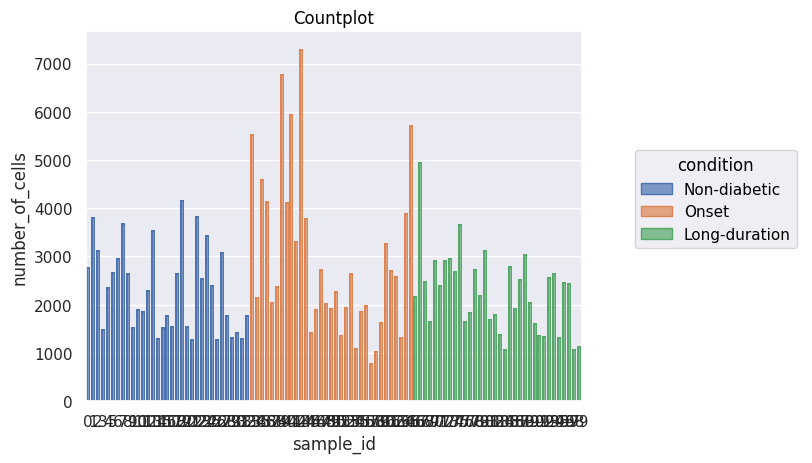

In [10]:
Analysis.plot_cell_counts()

In [8]:
Analysis.do_scaling("%quantile", 99.9)

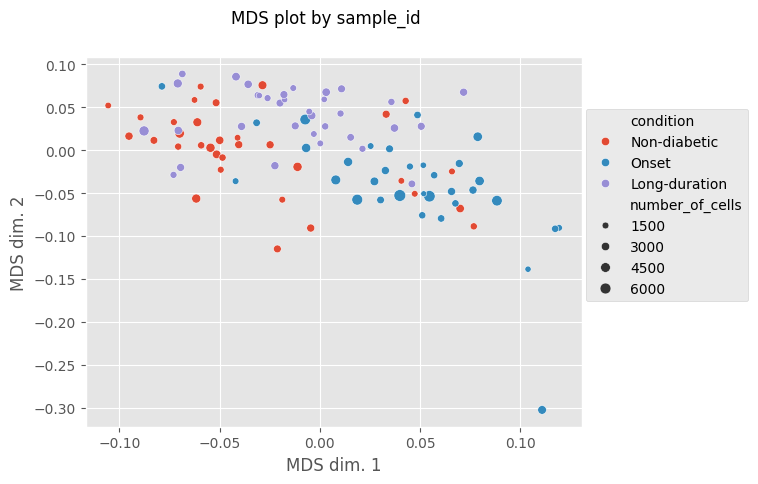

In [12]:
fig, mds_df = Analysis.plot_MDS(marker_class = 'type', color_by = 'condition')
fig

In [9]:
Analysis.do_flowsom(n_clusters = 20, rlen = 50, seed = 1234, scale_within_cells = True)
print(time.time() - start_timer)  ## keep track of time after each major step

2025-07-02 15:39:14.366 | DEBUG    | flowsom.main:__init__:82 - Reading input.
2025-07-02 15:39:14.402 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.
2025-07-02 15:41:07.954 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.


257.88145780563354


In [ ]:
#plot = Analysis.plot_scatter('CD4','CD8a', hue = 'Density')

In [33]:
### For some checks (such as in do_regions), need the masks in the masks folder to only be those used in the Analysis
## only needs ot be run once
import tifffile as tf
subset_masks = [i for i in os.listdir(ImageAnalysis.directory_object.masks_dir + "/Masks") if i in os.listdir(ImageAnalysis.directory_object.img_dir + "/ImageSubset")]
if not os.path.exists(ImageAnalysis.directory_object.masks_dir + "/MasksSubset"):
    os.mkdir(ImageAnalysis.directory_object.masks_dir + "/MasksSubset")
for i in subset_masks:
    image = tf.imread(ImageAnalysis.directory_object.masks_dir + f"/Masks/{i}")
    tf.imwrite(ImageAnalysis.directory_object.masks_dir + f"/MasksSubset/{i}", image)

In [12]:
Analysis.do_regions(ImageAnalysis.directory_object.masks_dir + "/islet_masks", mask_folder = ImageAnalysis.directory_object.masks_dir + "/MasksSubset")

In [13]:
Analysis.data.obs['regions'].unique()

array(['0', '1_1', '2_1', '1_2', '2_2', '3_2', '1_3', '2_3', '3_3', '1_4',
       '1_5', '2_5', '1_6', '2_6', '1_7', '2_7', '2_8', '3_8', '4_8',
       '1_9', '2_9', '1_10', '1_11', '2_11', '1_12', '1_13', '1_14',
       '2_14', '3_14', '1_15', '1_16', '2_16', '1_17', '2_17', '1_18',
       '1_19', '2_19', '3_19', '1_20', '2_20', '3_20', '4_20', '1_21',
       '2_21', '1_22', '1_23', '2_23', '3_23', '4_23', '1_24', '2_24',
       '2_25', '1_25', '3_25', '1_26', '2_26', '1_27', '2_27', '3_28',
       '1_28', '2_28', '1_29', '2_29', '1_30', '1_31', '1_32', '2_32',
       '1_33', '2_33', '1_34', '2_34', '3_34', '1_35', '1_36', '2_36',
       '3_36', '5_36', '4_36', '1_37', '2_37', '3_37', '4_37', '1_38',
       '2_38', '1_39', '2_39', '3_39', '1_40', '2_40', '3_40', '4_40',
       '5_40', '6_40', '7_40', '8_40', '2_41', '1_41', '3_41', '4_41',
       '1_42', '2_42', '3_42', '4_42', '1_43', '2_43', '3_43', '2_44',
       '3_44', '4_44', '5_44', '7_44', '1_45', '2_45', '3_45', '1_46',
     

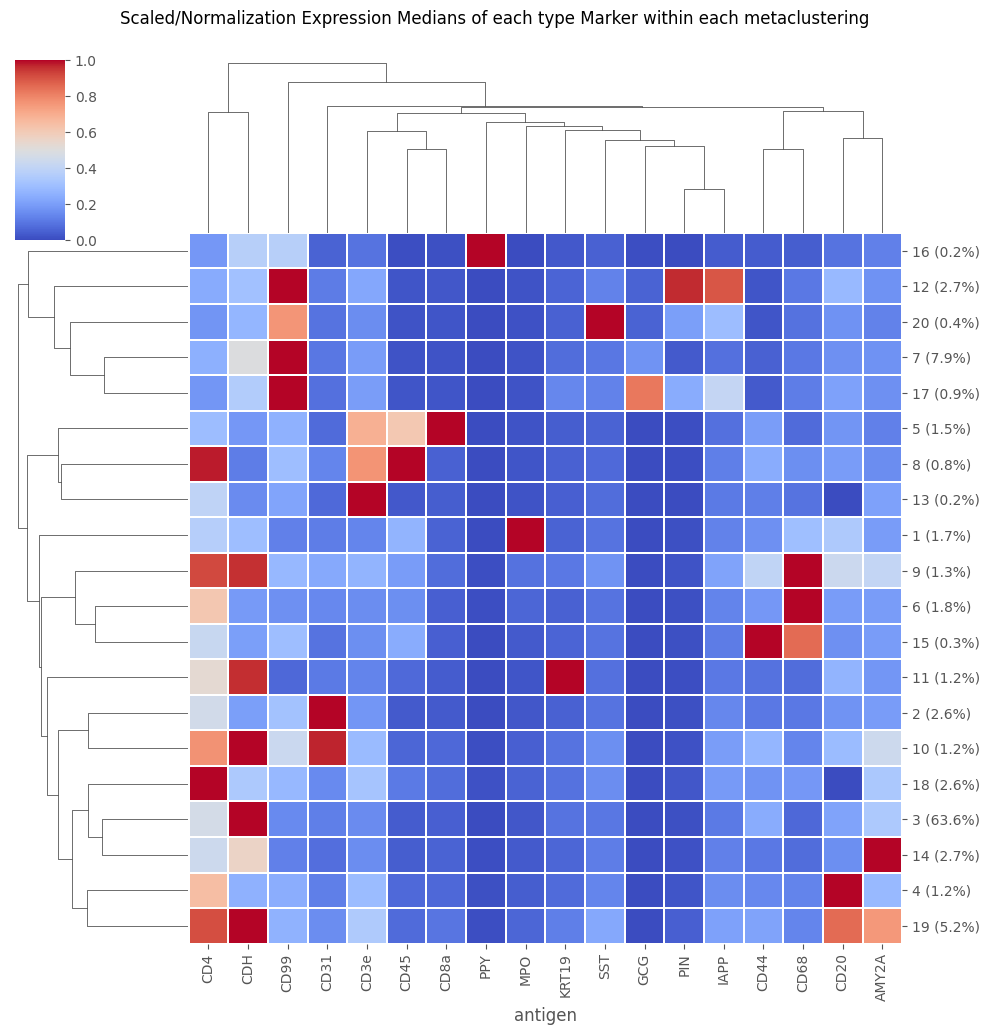

In [11]:
fig = Analysis.plot_medians_heatmap(marker_class = 'type', groupby = 'metaclustering')

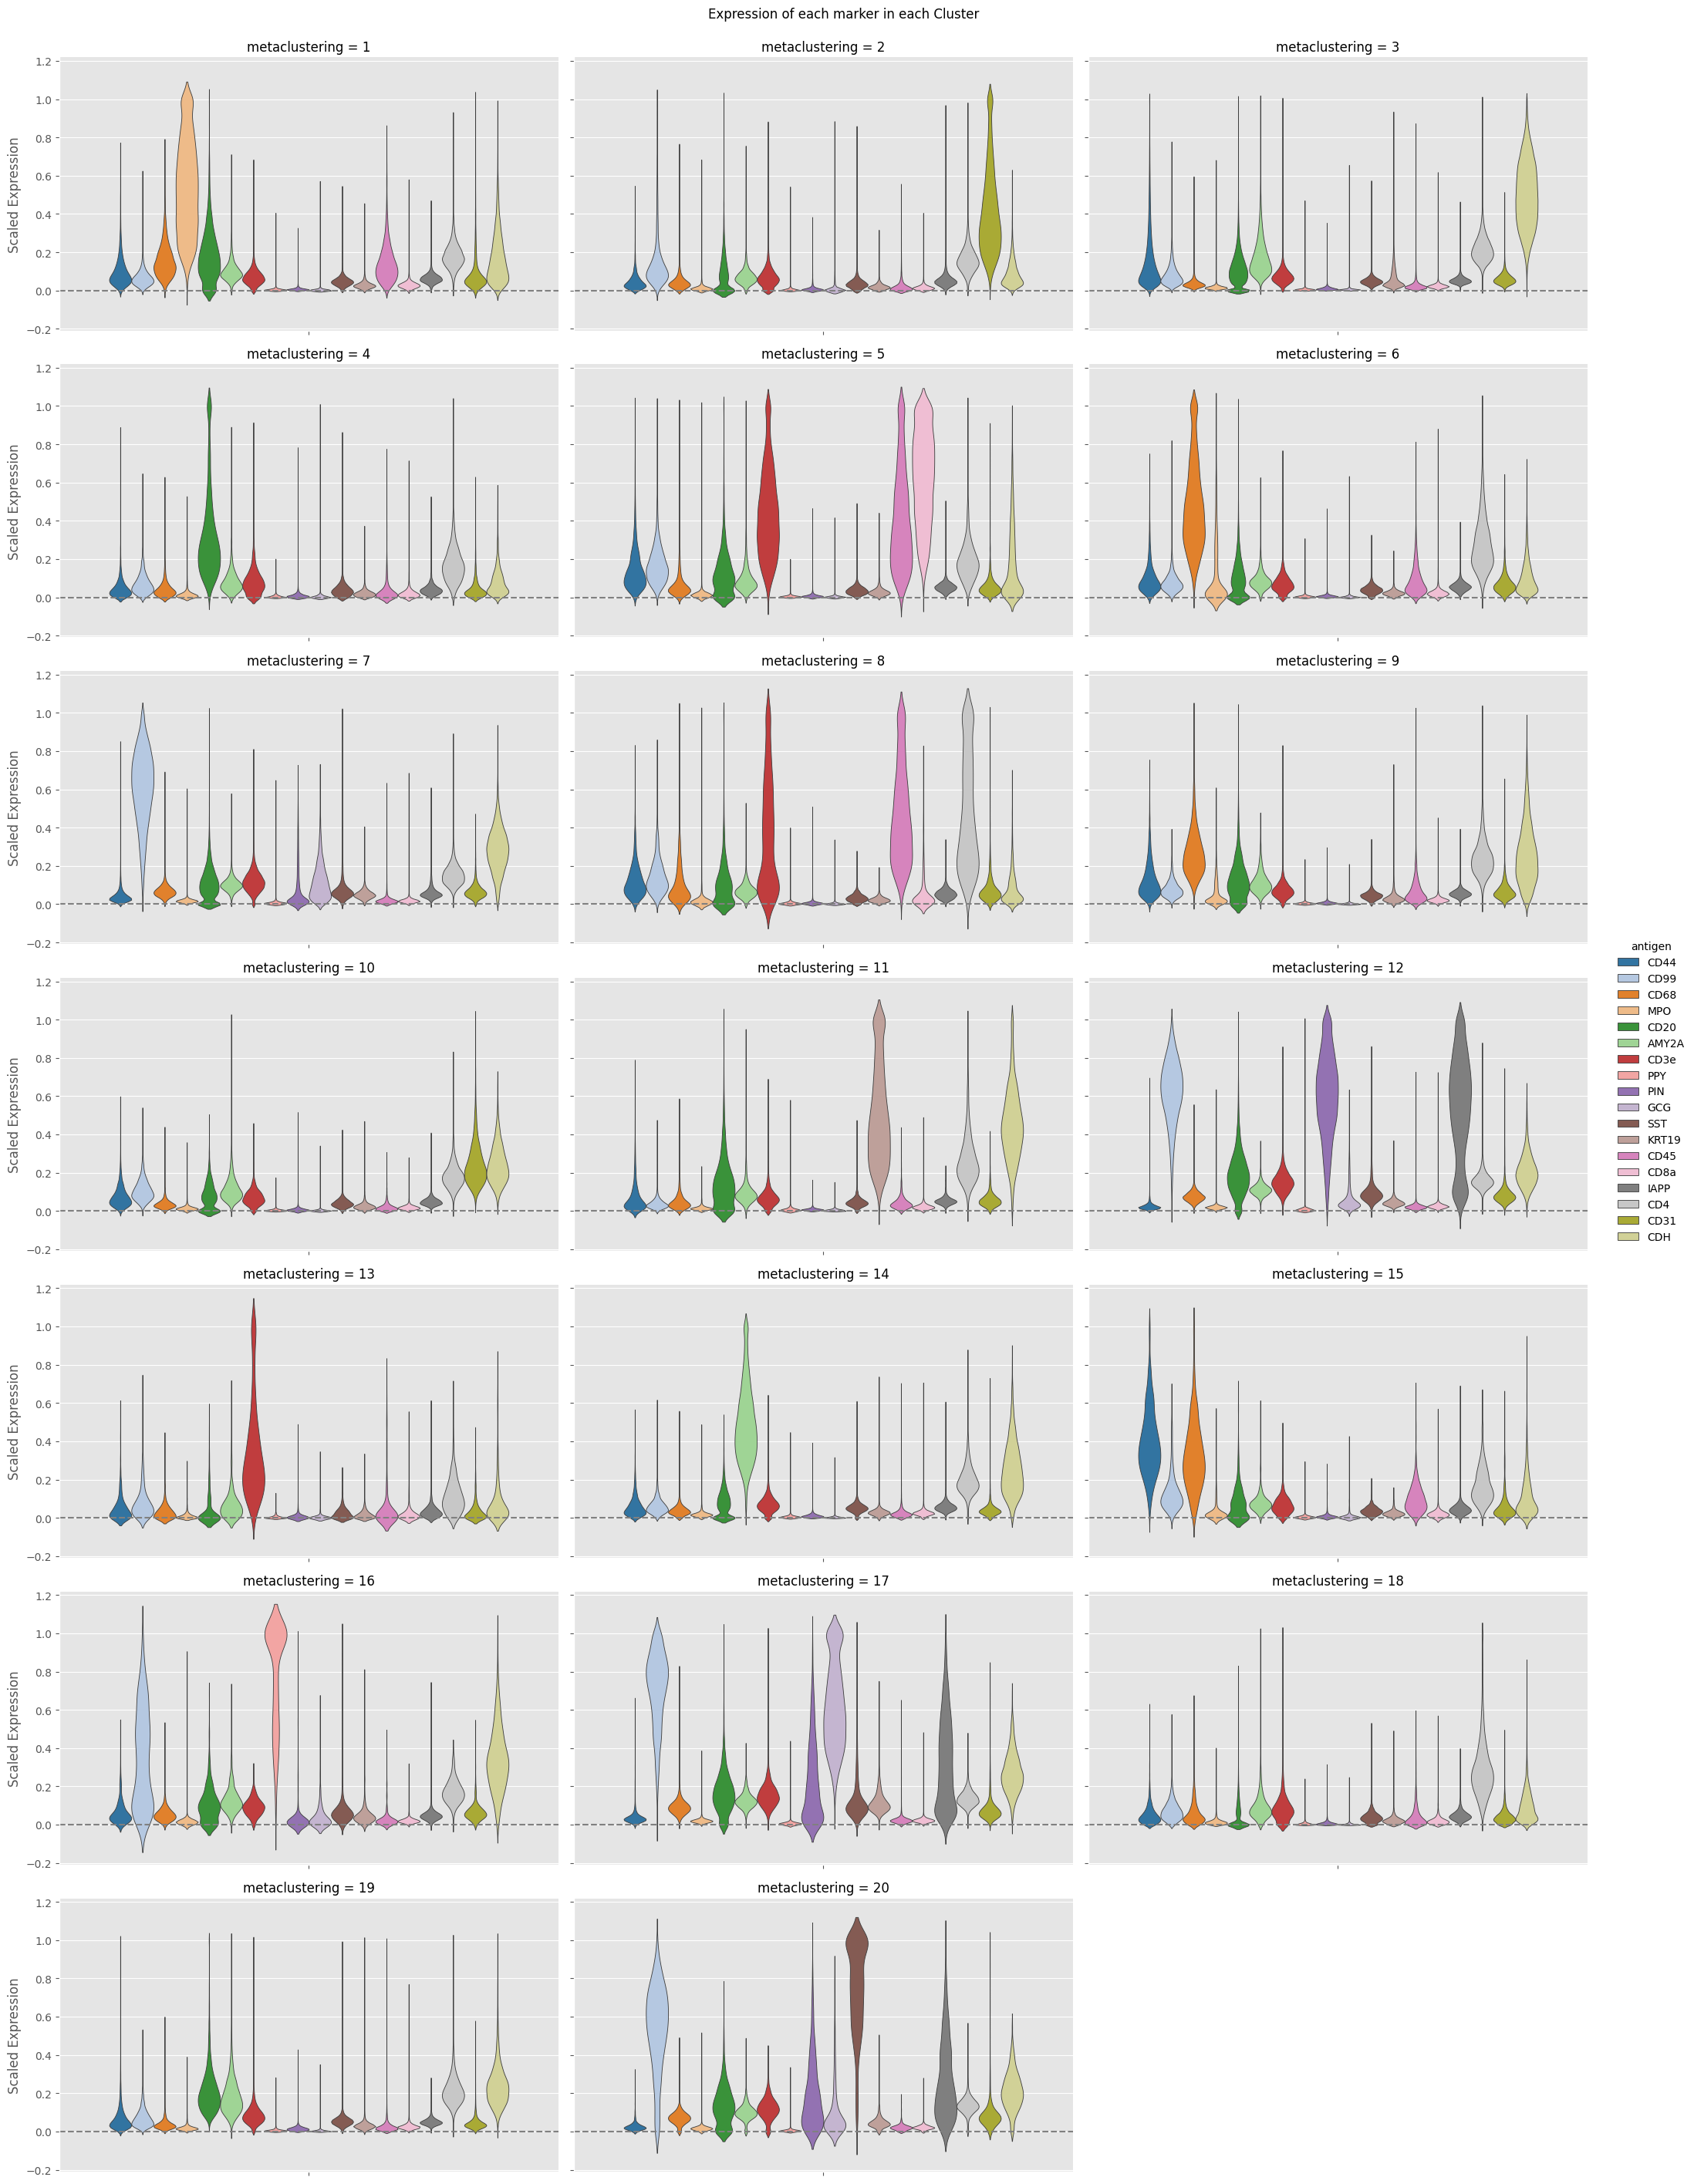

In [12]:
Analysis.plot_cluster_distributions(groupby_column = 'metaclustering', plot_type = 'violin')

In [14]:
Analysis.do_UMAP(marker_class = 'type', cell_number = 1000, seed = 42)
print(time.time() - start_timer) 

C:\Users\benca\miniforge3\envs\main\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1123.31445646286


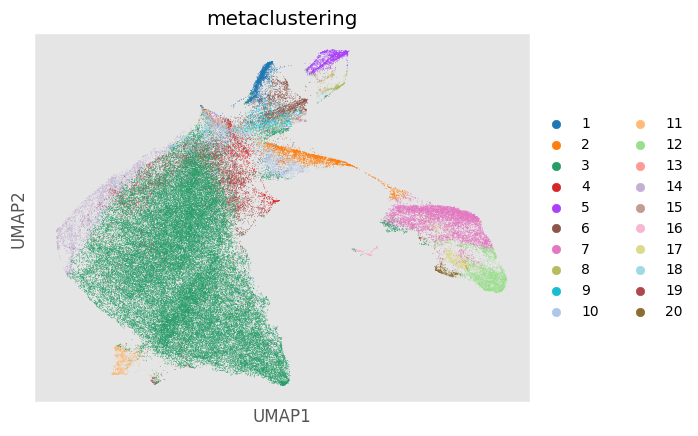

In [15]:
Analysis.plot_UMAP(color_by = 'metaclustering')

## Annotation

Paper's annotation categories: alpha, beta, gamma, delta cells (islets), Tc, Naive Tc, Th, B, Mono, 
Neutrophils, Other immune (immune), Acinar, Ductal, Endothelial, Stromal, Unknown

my protein assignments:

    (islet) -- CD99 positive, CHD negative -- (multiple clusters)
    alpha -- GCG -- cluster #17, 7
    beta -- PIN, IAPP -- cluster #12
    gamma -- PPY  -- cluster #16
    delta -- SST -- cluster #20

    (immune) -- CD45+ -- (multiple clusters, not very clean for CD45)
    Tc -- CD3+, CD8+, CD45RA negative -- cluster #5
    Naive Tc -- CD3, CD8, CD45RA -- cluster # N/A      >>> CD45RA removed as an unreliable / unhelpful marker. Perhaps try adding back
    Th -- CD3, CD4 -- cluster #8, 13
    B -- CD20 -- cluster #4
    Mono -- CD68 -- cluster #6,9,15
    neutrophil -- MPO -- cluster #1
    Other immune -- CD45, nothing else -- No clusters

    (exocrine) --  -- (multiple clusters)
    Acinar -- AMY2A -- cluster #14, 19
    Ductal -- KRT19 -- cluster #11

    Stroma -- CDH, neg for all else -- cluster #3     (63% ! -- would prefer this split up [?])

    Endothelial -- CD31 -- cluster #2, 10

    Unknown -- all neg, impossible clusters -- cluster #18  (maybe 7)

In [10]:
numbers = [str(i) for i in range(1,21,1)]
cell_assignments = ["neutrophil","Endothelial","Stroma","B","Tc",    ### ordered list of assignments from cluster 1-->20
                       "Mono","alpha","Th","Mono","Endothelial",
                      "Ductal","beta","Th","Acinar","Mono",
                      "gamma","alpha","Unknown","Acinar","delta"]
replacement_dict = dict(zip(numbers,cell_assignments))
Analysis.data.obs['cell_merging'] = Analysis.data.obs['metaclustering'].astype('str').replace(replacement_dict).astype('category') 
Analysis.UMAP_embedding.obs['cell_merging'] = Analysis.UMAP_embedding.obs['metaclustering'].astype('str').replace(replacement_dict).astype('category') 

In [18]:
Analysis.data.obs

,sample_id,file_name,patient_id,condition,clustering,metaclustering,regions,cell_merging
0,0,E02_a0_full.fcs,Tail,Non-diabetic,85,3,0,Stroma
1,0,E02_a0_full.fcs,Tail,Non-diabetic,70,3,0,Stroma
2,0,E02_a0_full.fcs,Tail,Non-diabetic,94,3,0,Stroma
3,0,E02_a0_full.fcs,Tail,Non-diabetic,70,3,0,Stroma
4,0,E02_a0_full.fcs,Tail,Non-diabetic,81,3,0,Stroma
...,...,...,...,...,...,...,...,...
252054,99,J34_a0_full.fcs,Tail,Long-duration,95,3,0,Stroma
252055,99,J34_a0_full.fcs,Tail,Long-duration,95,3,0,Stroma
252056,99,J34_a0_full.fcs,Tail,Long-duration,84,3,0,Stroma
252057,99,J34_a0_full.fcs,Tail,Long-duration,44,3,0,Stroma


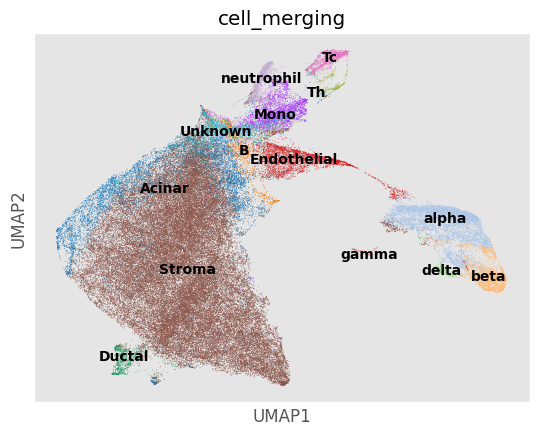

In [21]:
Analysis.plot_UMAP(color_by = 'cell_merging', legend_loc = 'on data')

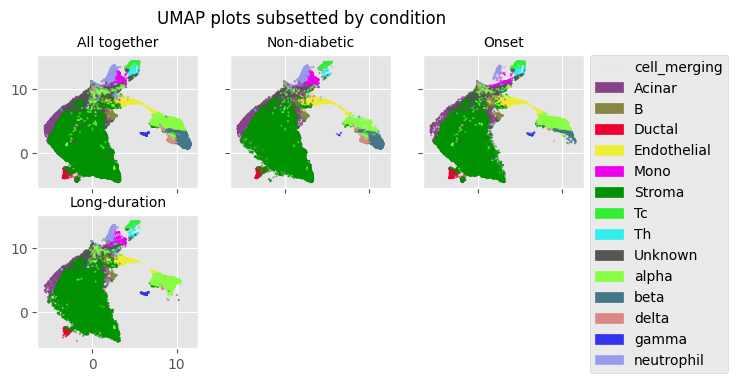

In [20]:
Analysis.plot_facetted_DR(color_by = 'cell_merging', kind = 'UMAP', subsetting_column = 'condition')

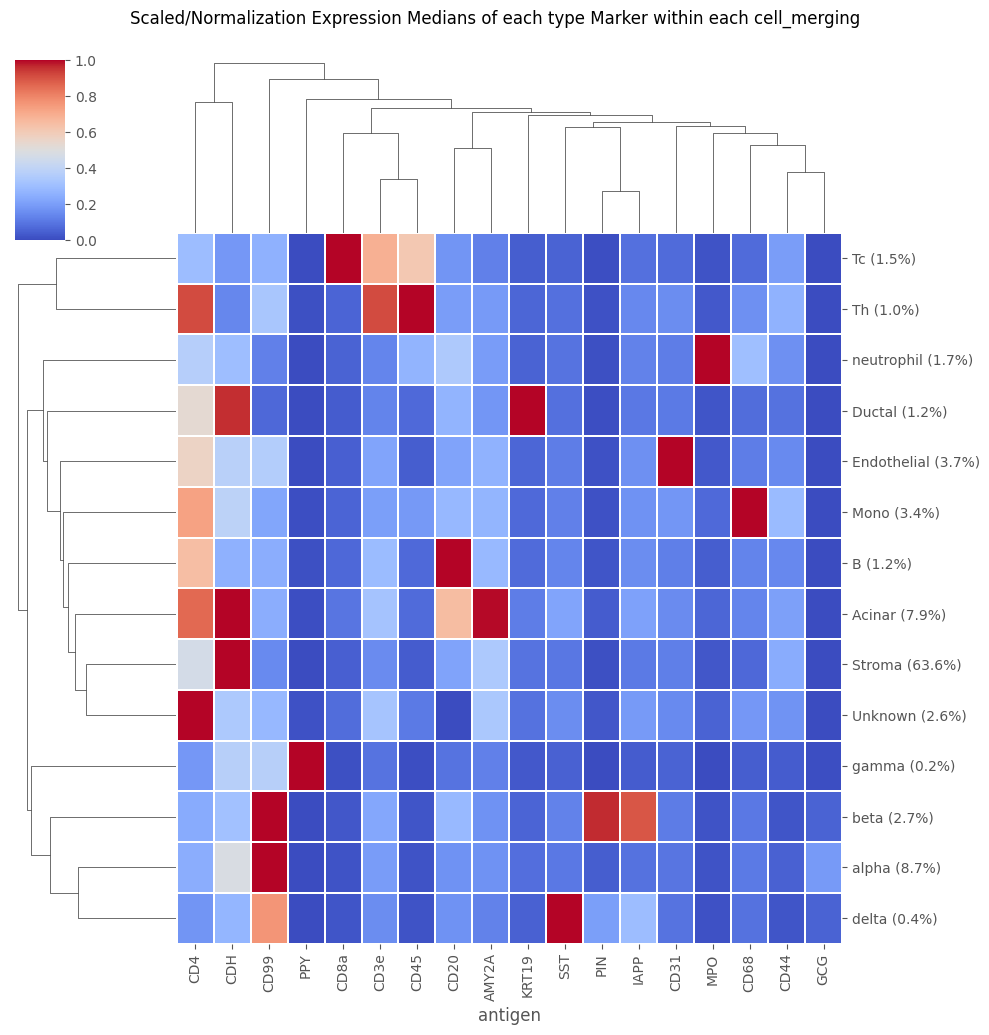

In [12]:
fig = Analysis.plot_medians_heatmap(marker_class = 'type', groupby = 'cell_merging')

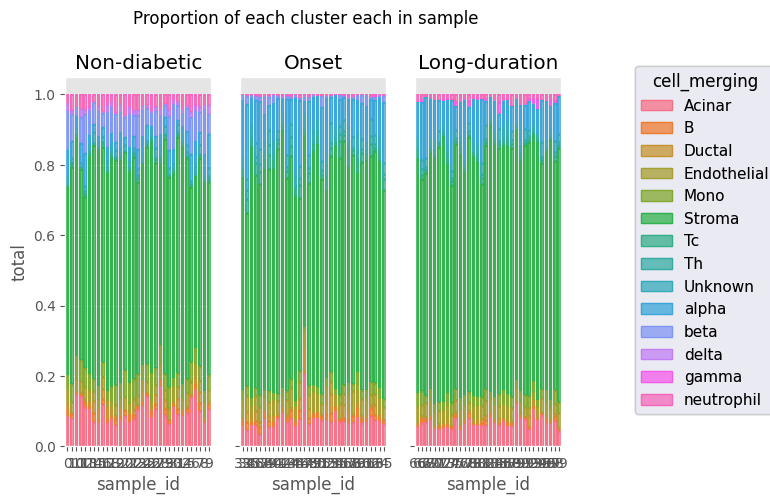

In [13]:
Analysis.plot_cluster_abundance_1(groupby_column = "cell_merging")

In [26]:
Analysis.data.obs['case'] = Analysis.metadata['case']
#Analysis.plot_cluster_abundance_1(groupby_column = "cell_merging", bars_by = 'case')

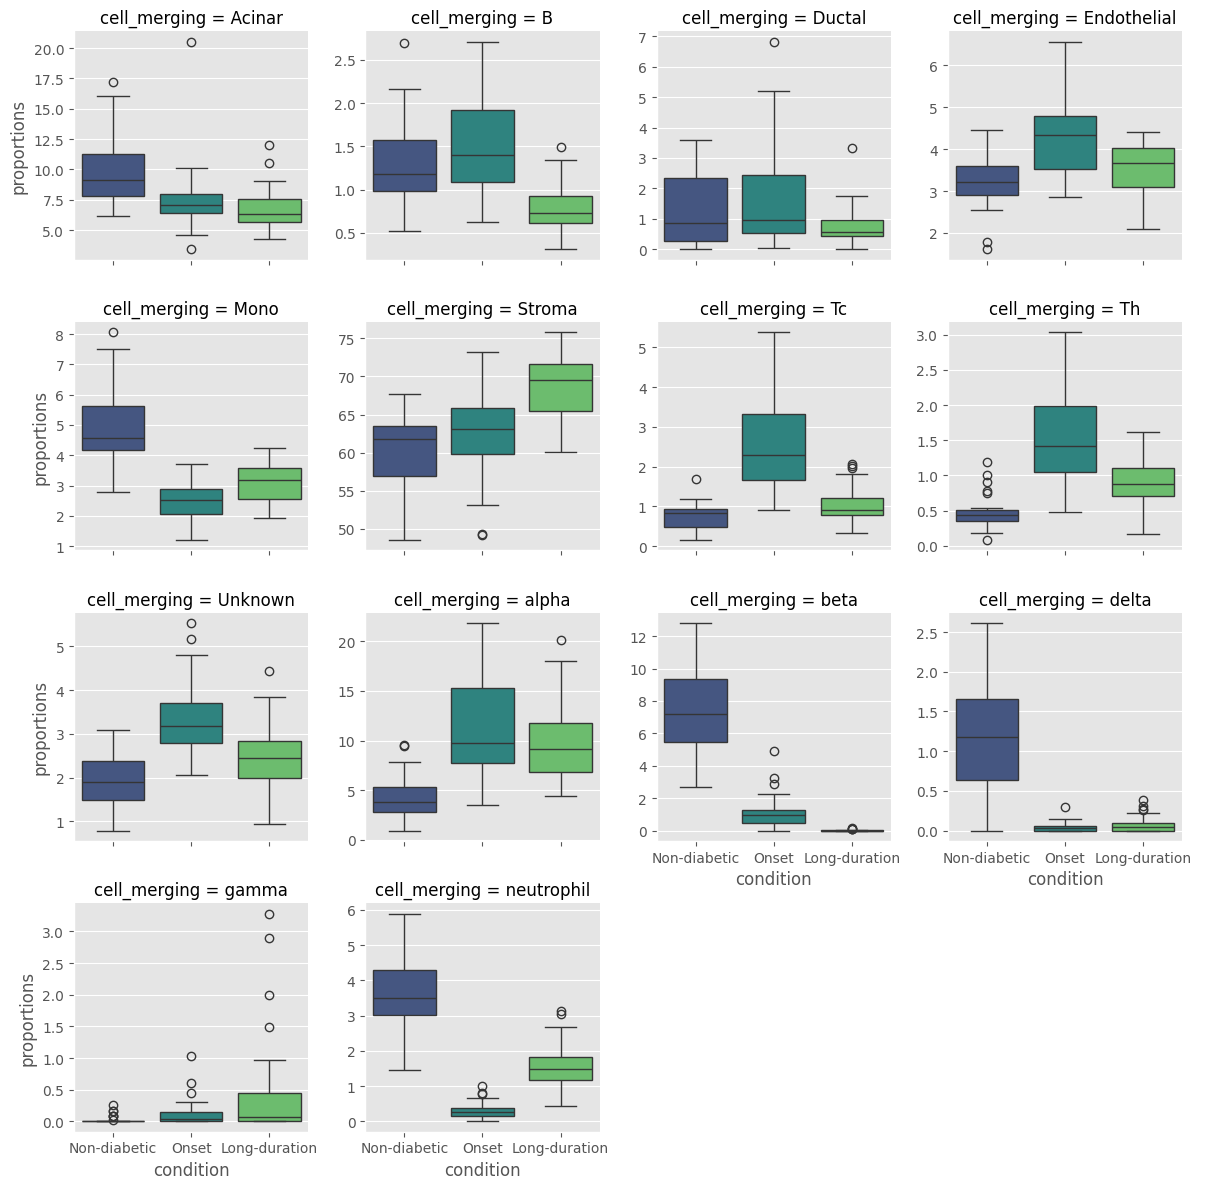

In [12]:
Analysis.plot_cluster_abundance_2(groupby_column = "cell_merging", hue = 'condition', plot_type = 'boxplot')

In [13]:
Analysis.do_count_GLM(variable = "condition", conditions = Analysis.data.obs['condition'].unique(), groupby_column = 'cell_merging', family = 'Poisson')

,comparison,cell_merging,pvalue,p_adj,Non-diabetic est. avg,Non-diabetic 95% CI +/-,Onset est. avg,Onset 95% CI +/-,Long-duration est. avg,Long-duration 95% CI +/-
5,Multiple Conditions,neutrophil,0.0,1.560000e-25,3.7,0.0695,0.306,0.0186,1.58,0.0541
10,Multiple Conditions,alpha,0.0,1.560000e-25,4.34,0.0752,11.1,0.22,10.1,0.209
12,Multiple Conditions,beta,0.0,1.560000e-25,7.37,0.098,1.25,0.0394,0.0169,0.00476
1,Multiple Conditions,Tc,1.74e-163,1.560000e-25,0.71,0.0304,2.57,0.121,1.04,0.0579
6,Multiple Conditions,Mono,1.84e-151,1.560000e-25,4.9,0.0799,2.48,0.0644,3.12,0.0816
11,Multiple Conditions,delta,5.36e-104,1.560000e-25,1.16,0.0389,0.0528,0.00756,0.0819,0.0107
8,Multiple Conditions,Th,6.96e-94,1.560000e-25,0.456,0.0244,1.54,0.0915,0.942,0.0614
4,Multiple Conditions,Acinar,3.87e-84,1.560000e-25,9.98,0.114,7.24,0.119,6.68,0.12
7,Multiple Conditions,Unknown,3.69e-72,1.560000e-25,1.9,0.0497,3.34,0.105,2.46,0.0857
2,Multiple Conditions,Endothelial,5.05e-26,2.110000e-25,3.26,0.0652,4.25,0.108,3.52,0.0977


In [23]:
Analysis.filter_data('0_0','regions')

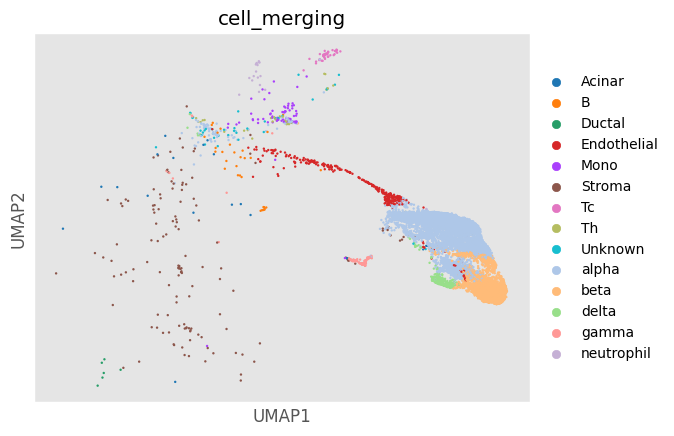

In [25]:
Analysis.plot_UMAP(color_by = 'cell_merging')

In [102]:
regions_df = pd.DataFrame(Analysis.data.X, index = Analysis.data.obs.index, columns = list(Analysis.data.var.index))
transfer_columns = ['sample_id','regions','cell_merging','condition']
regions_df[transfer_columns] = Analysis.data.obs[transfer_columns]

In [163]:
rep_channels = ['PIN','IAPP','PDX1','SYP','INS','PTPRN','NKX6-1','CD99']
rep_df = regions_df[['sample_id','regions','cell_merging','condition','PIN','IAPP','PDX1','SYP','INS','PTPRN','NKX6-1','CD99']]
rep_df = rep_df.melt(transfer_columns)

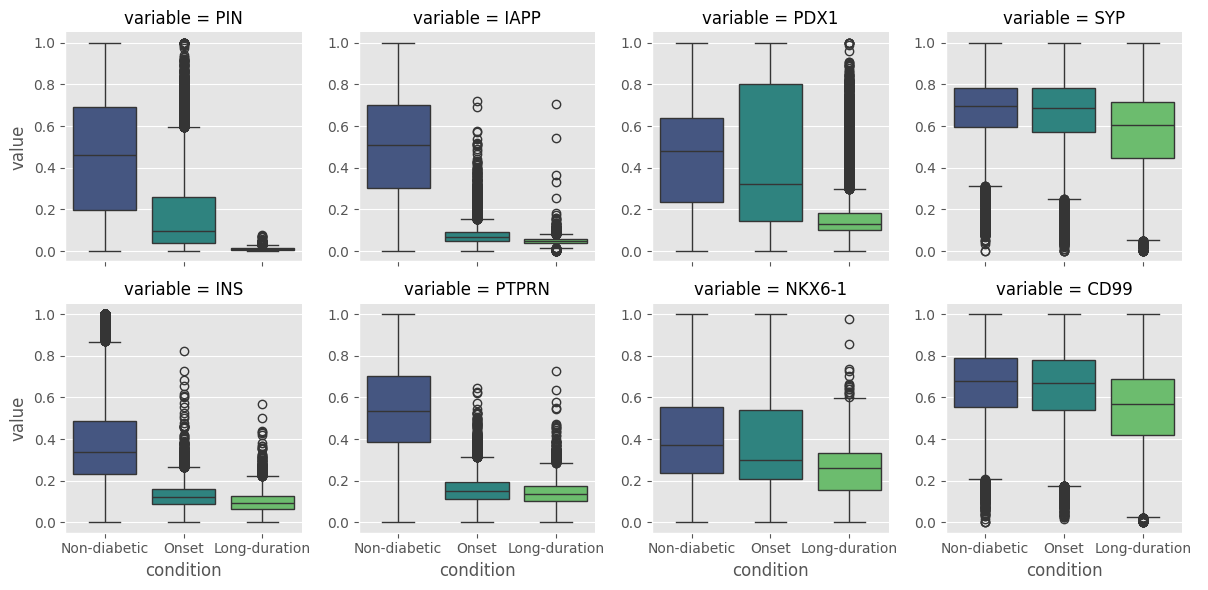

In [164]:
Grid = sns.FacetGrid(rep_df, col = 'variable', col_wrap = 4, sharey = False)
Grid.map_dataframe(sns.boxplot, x = 'condition', y = 'value', hue = 'condition', palette = 'viridis')
Grid.add_legend()
plt.show()

In [103]:
islet_cells = regions_df.groupby(['regions','condition','cell_merging'], observed = True).count().reset_index()[['regions','condition','cell_merging','H3']]
islet_totals = regions_df.groupby(['regions'], observed = True).count().reset_index()[['regions','pH3']]
islet_cells = pd.merge(islet_cells, islet_totals, on = 'regions')
islet_cells['percent'] = (islet_cells['H3'] / islet_cells['pH3'])*100

<Axes: xlabel='condition', ylabel='percent'>

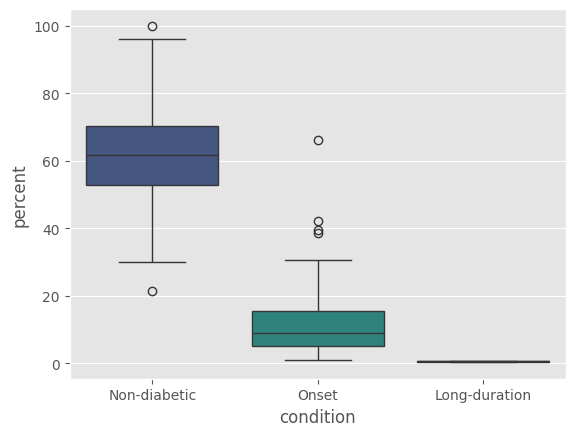

In [148]:
sns.boxplot(islet_cells[islet_cells['cell_merging'] == 'beta'], x = 'condition', y = 'percent', hue = 'condition', palette = 'viridis')

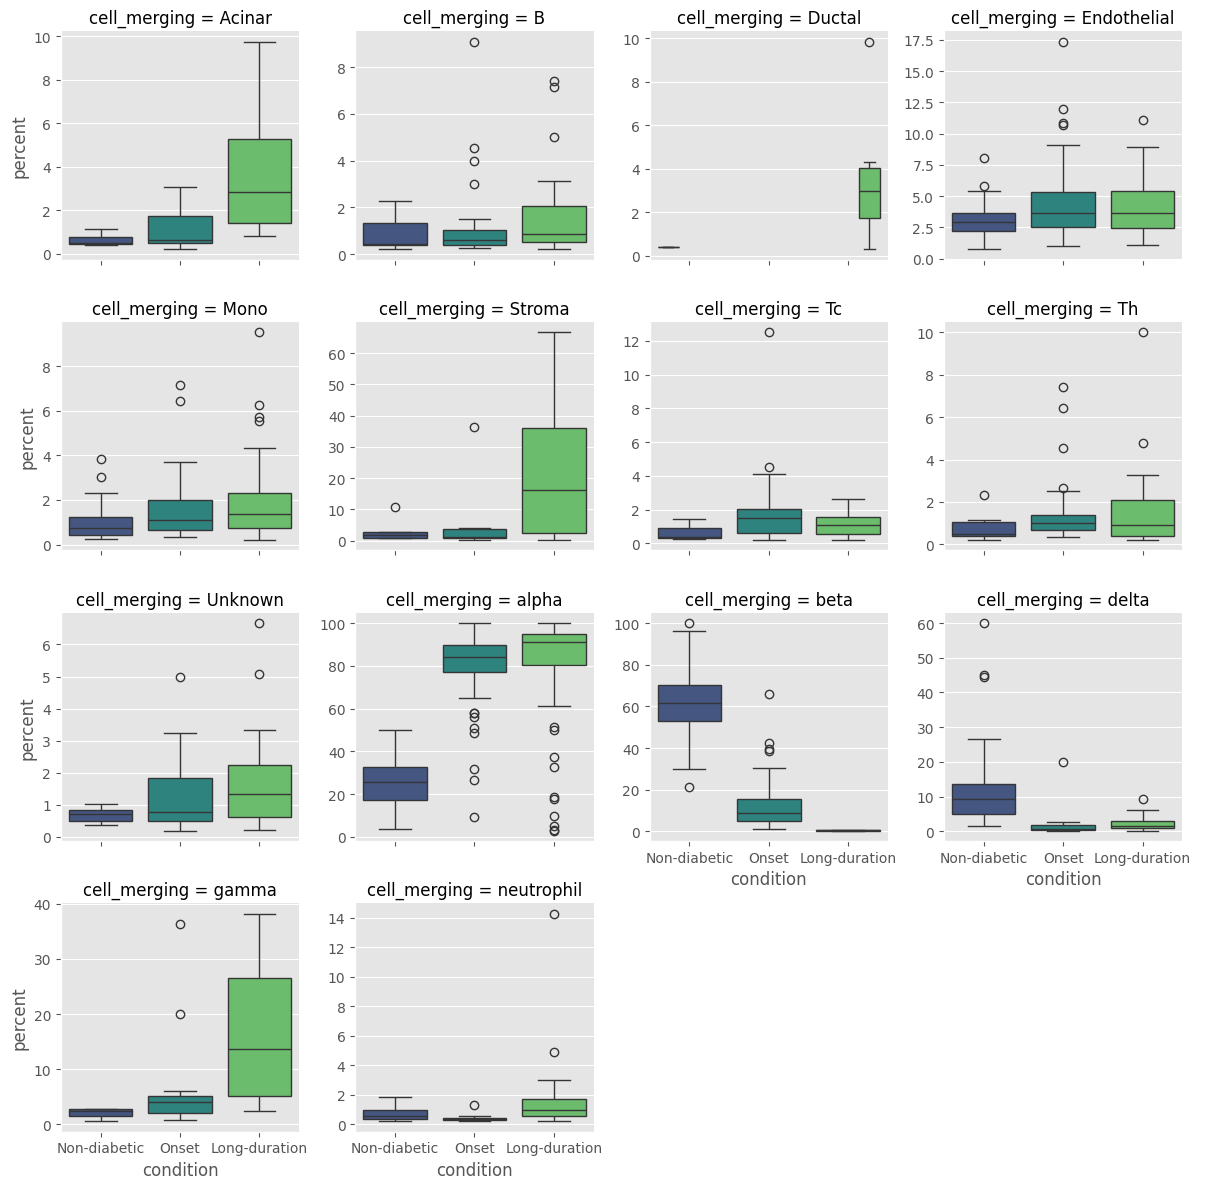

In [107]:
Grid = sns.FacetGrid(islet_cells, col = 'cell_merging', col_wrap = 4, sharey = False)
Grid.map_dataframe(sns.boxplot, x = 'condition', y = 'percent', hue = 'condition', palette = 'viridis')
Grid.add_legend()
plt.show()

In [124]:
import anndata
by_region = regions_df.groupby('regions').mean(numeric_only = True).reset_index()
by_region_ann = anndata.AnnData(X = np.array(by_region.drop('regions', axis = 1)), obs = pd.DataFrame(by_region['regions']), var = pd.DataFrame(Analysis.data.var))
by_region_ann = by_region_ann[:,by_region_ann.var['marker_class'] == 'type']

In [140]:
zip_dict = {}
for i in regions_df['regions'].unique():
    zip_dict[i] = regions_df[regions_df['regions'] == i]['condition'].values[0]
by_region_ann.obs['condition'] = by_region_ann.obs['regions'].replace(zip_dict).astype(Analysis.data.obs['condition'].dtype)

In [150]:
by_region_ann.obs

,regions,condition,dpt_pseudotime
0,1_1,Non-diabetic,0.000000
1,1_10,Non-diabetic,0.105988
2,1_100,Long-duration,0.898194
3,1_11,Non-diabetic,0.033460
4,1_12,Non-diabetic,0.117913
...,...,...,...
211,6_66,Onset,0.954883
212,7_40,Onset,0.927040
213,7_44,Onset,0.935908
214,7_66,Onset,0.966880


In [142]:
sc.pp.neighbors(by_region_ann)

C:\Users\benca\miniforge3\envs\main\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


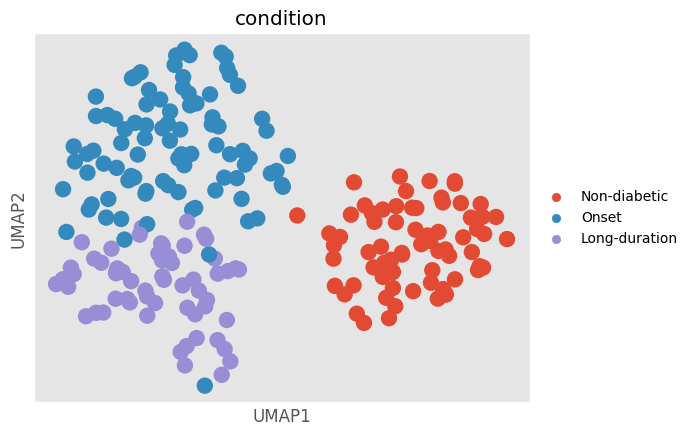

In [282]:
sc.tl.umap(by_region_ann, min_dist = 2.5)
sc.pl.umap(by_region_ann, color = 'condition')

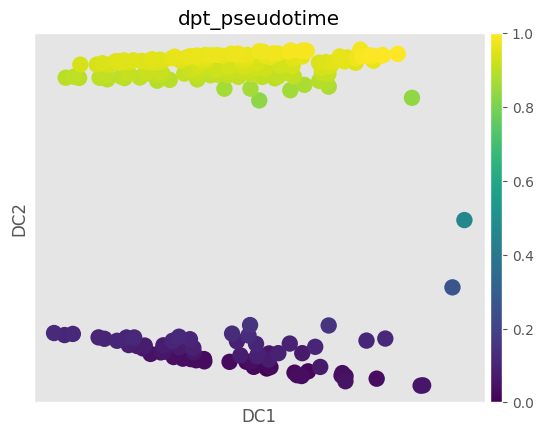

In [144]:
sc.tl.diffmap(by_region_ann)
by_region_ann.uns['iroot'] = 0
sc.tl.dpt(by_region_ann, n_dcs = 10)
sc.pl.diffmap(by_region_ann, color = 'dpt_pseudotime')

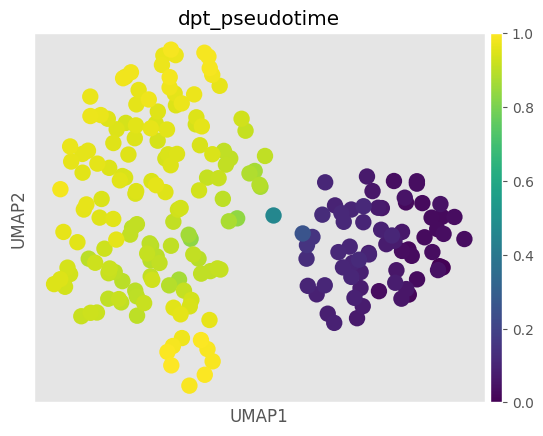

In [145]:
sc.pl.umap(by_region_ann, color = 'dpt_pseudotime')

<Axes: xlabel='condition', ylabel='dpt_pseudotime'>

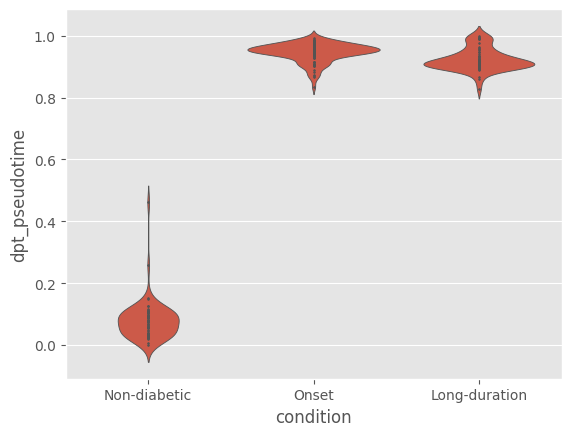

In [146]:
sns.violinplot(x = by_region_ann.obs['condition'], y = by_region_ann.obs['dpt_pseudotime'], inner = 'point')

<Axes: xlabel='condition', ylabel='dpt_pseudotime'>

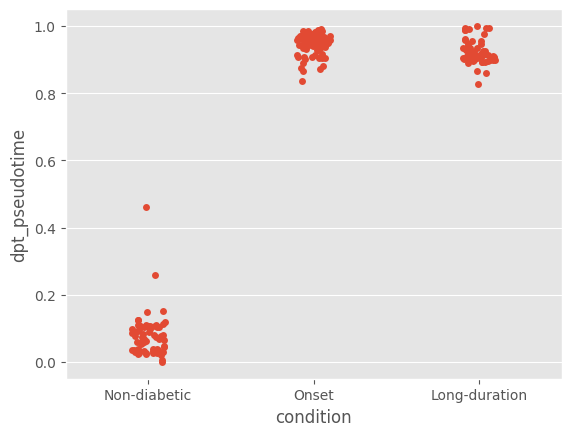

In [147]:
sns.stripplot(x = by_region_ann.obs['condition'], y = by_region_ann.obs['dpt_pseudotime'])

In [189]:
### Pseudotime Derived from a later cell
Analysis.data.obs = pd.merge(Analysis.data.obs, by_region_ann.obs[['regions','dpt_pseudotime']], on = 'regions')

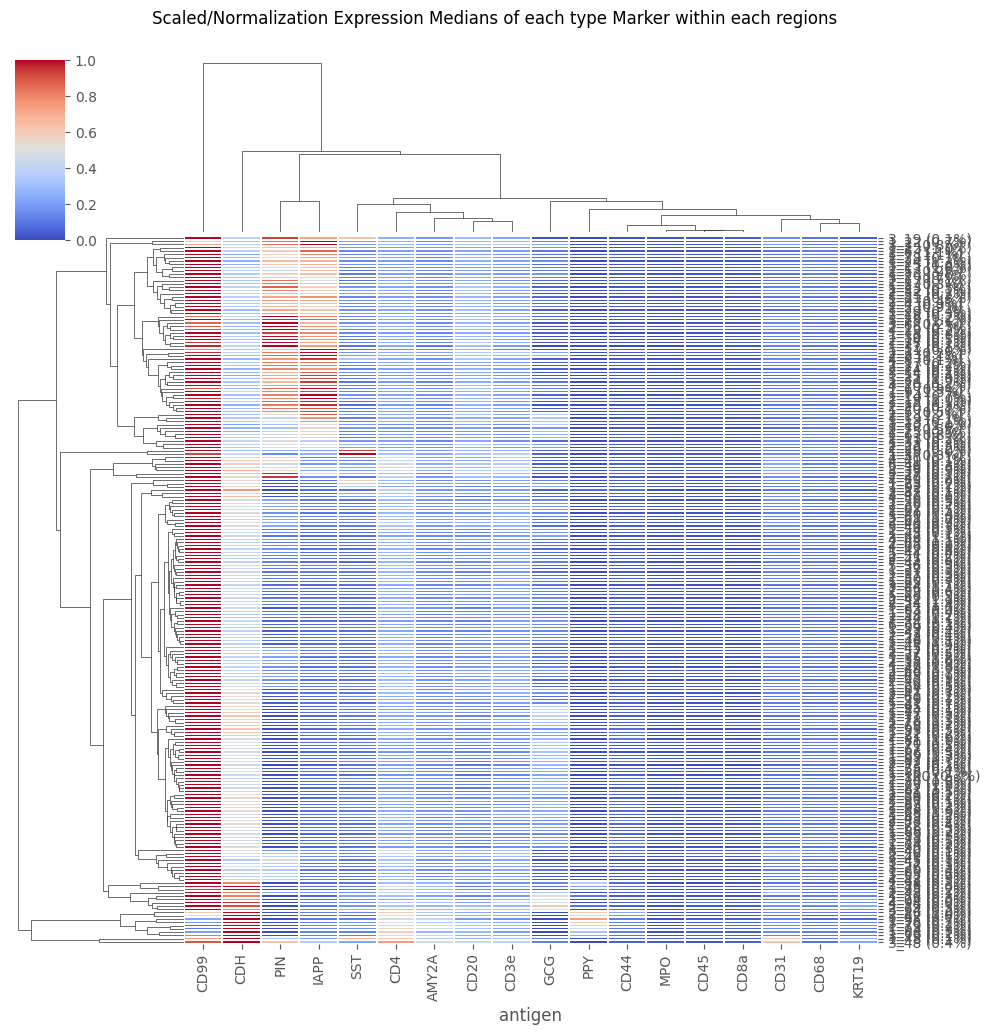

In [279]:
fig = Analysis.plot_medians_heatmap(marker_class = 'type', groupby = 'regions')

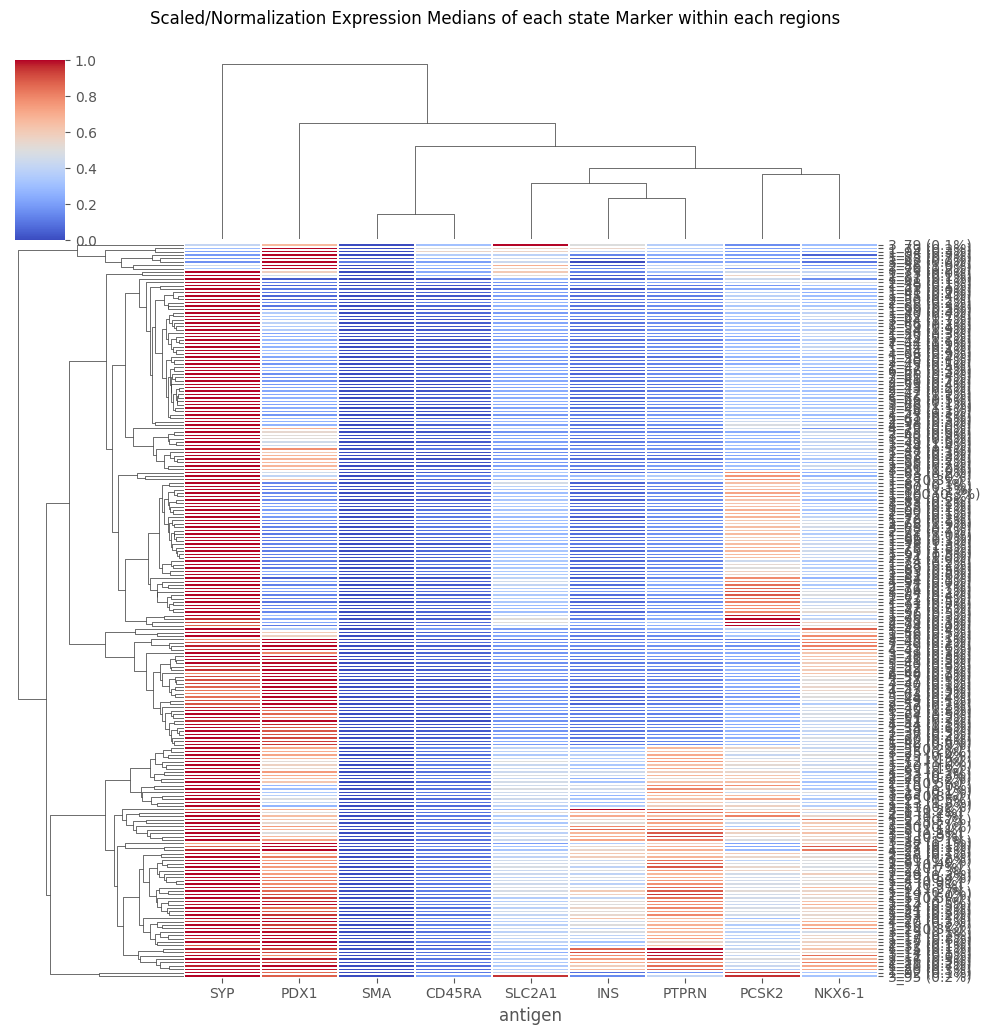

In [284]:
Analysis.data.var.index = Analysis.data.var['antigen']

rep_channels = ['PIN','IAPP','PDX1','SYP','INS','PTPRN','NKX6-1','CD99','PCSK2','GCG','SLC2A1','SST']
Analysis.data.var.loc[rep_channels,'marker_class'] = 'subset'
fig = Analysis.plot_medians_heatmap(marker_class = 'subset', groupby = 'regions')
Analysis.data.var.loc[rep_channels,'marker_class'] = 'type'

In [193]:
immune_types = ['B','Th','Tc','Mono','neutrophil']

In [253]:
previous = 0
sample_id = 1
regions_list = []
for i in IsletAnalysis.regionprops_data.index:
    if i <= previous:
        sample_id += 1
    regions_list.append(f'{str(i)}_{str(sample_id)}')
    previous = i 

In [262]:
IsletAnalysis.regionprops_data

,area_x,perimeter_x,axis_major_length_x,axis_minor_length_x,eccentricity_x,regions,sample_id,file_name,patient_id,condition,clustering,metaclustering,cell_merging,dpt_pseudotime,area_y,perimeter_y,axis_major_length_y,axis_minor_length_y,eccentricity_y
0,27836.0,832.778787,227.913736,168.096701,0.675298,1_1,0,E02_a0_full.fcs,Tail,Non-diabetic,21,20,delta,0.000000,27836.0,832.778787,227.913736,168.096701,0.675298
1,27836.0,832.778787,227.913736,168.096701,0.675298,1_1,0,E02_a0_full.fcs,Tail,Non-diabetic,21,20,delta,0.000000,27836.0,832.778787,227.913736,168.096701,0.675298
2,27836.0,832.778787,227.913736,168.096701,0.675298,1_1,0,E02_a0_full.fcs,Tail,Non-diabetic,0,12,beta,0.000000,27836.0,832.778787,227.913736,168.096701,0.675298
3,27836.0,832.778787,227.913736,168.096701,0.675298,1_1,0,E02_a0_full.fcs,Tail,Non-diabetic,10,12,beta,0.000000,27836.0,832.778787,227.913736,168.096701,0.675298
4,27836.0,832.778787,227.913736,168.096701,0.675298,1_1,0,E02_a0_full.fcs,Tail,Non-diabetic,40,17,alpha,0.000000,27836.0,832.778787,227.913736,168.096701,0.675298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27134,6330.0,603.085353,119.709783,75.692450,0.774724,1_100,99,J34_a0_full.fcs,Tail,Long-duration,51,7,alpha,0.898194,6330.0,603.085353,119.709783,75.692450,0.774724
27135,6330.0,603.085353,119.709783,75.692450,0.774724,1_100,99,J34_a0_full.fcs,Tail,Long-duration,30,7,alpha,0.898194,6330.0,603.085353,119.709783,75.692450,0.774724
27136,6330.0,603.085353,119.709783,75.692450,0.774724,1_100,99,J34_a0_full.fcs,Tail,Long-duration,30,7,alpha,0.898194,6330.0,603.085353,119.709783,75.692450,0.774724
27137,6330.0,603.085353,119.709783,75.692450,0.774724,1_100,99,J34_a0_full.fcs,Tail,Long-duration,30,7,alpha,0.898194,6330.0,603.085353,119.709783,75.692450,0.774724


In [264]:
IsletAnalysis.regionprops_data['regions'] = regions_list
IsletAnalysis.regionprops_data = pd.merge(IsletAnalysis.regionprops_data, Analysis.data.obs, on = 'regions', suffixes = ["","_y"])

<Axes: xlabel='condition', ylabel='eccentricity'>

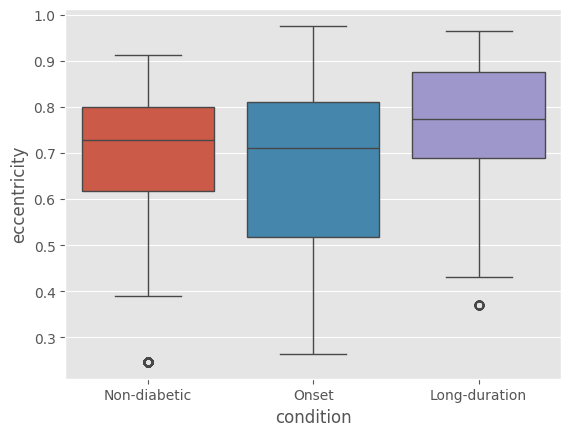

In [266]:
sns.boxplot(IsletAnalysis.regionprops_data, y = 'eccentricity', x = 'condition', hue = 'condition')

<Axes: xlabel='condition', ylabel='area'>

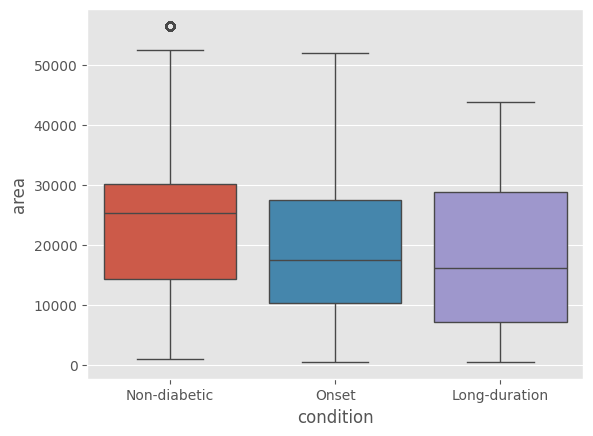

In [267]:
sns.boxplot(IsletAnalysis.regionprops_data, y = 'area', x = 'condition', hue = 'condition')

In [23]:
## Setup, train, and run a supervised classifier for pancreatic islets. 
## CRTIICAL: the training labels (one .tiff) were already made for this from inside the GUI / Napari, which is included in the folder with this script
    ## So I don't bother showing its annotation here, it is simply automatically loaded. To repeat, take the training_labels files and placed inside the
    ## the training labels folder of the islet classifier, once it has been setup from this script.


sup_classifier_name = "Classifier_1.json"
px_classifier = palmettobug.SupervisedClassifier(homedir = directory)
classes = {1:'background', 2:'islet'}
sigma_list = [1.0,2.0,4.0]
features = ['GAUSSIAN','LAPLACIAN']
channels = {
        "SMA": 1,
        "PCSK2": 5,
        "CD99": 6,
        "AMY2A": 11,
        "PPY": 13,
        "PDX1": 16,
        "KRT19": 19,
        "CD45": 20,
        "CD31": 30,
        "CDH": 31,
        "PTPRN": 32,
        "Ir191": 34
    }
image_directory = directory + "/images/ImageSubset"
model, details = px_classifier.setup_classifier(classifier_name = sup_classifier_name, 
                               number_of_classes = 2, 
                               sigma_list = sigma_list, 
                               features_list = features, 
                               channel_dictionary = channels,
                               image_directory = image_directory)

100

In [80]:
px_classifier.train_folder(image_directory)
px_classifier.predict_folder(image_directory)   ## train / predict / segment only has to be run once -- the generated masks can be used without needing to re-do

In [82]:
## Note! This method of islet segmentation is vulernable to a few errors:
    # 1). Very large islets can be split into multiple (two or more, depending on how large!) masks. This is dependent on centroid <--> centroid distance
        # with lower numbers for this parameter favoring smaller / more fragmented masks
    # 2). islets close (but discontinuous) to another islet can be ignored -- this is dependent on the centroid <--> centroid distance specified, with
        # higher numbers for this parameter more likely to cause islets to be ignored when masking.
## the second problem should be more likely to affect small islets (as their centroids are likely to be closer to their surface), visually this seemed to be the case 
## when testing different centroid distances when segmenting. 
## I visually checked the output of this segmentation (inside the GUI, using the 'quick display' feature of the directory navigator) for many of the ROIs. I could see 
## instances of both problems listed above, which could not be entirely avoided as increasing the centroid <--> centroid distance might solve problem #1, but would 
# make problem #2 worse (And vice versa).
# I tested (not rigorously systematically) different parameters for the centroids (mostly) and size threshold and settled on the values below:

islet_mask_folder = f"{directory}/masks/islet_masks"
palmettobug.segment_class_map_folder(px_classifier.output_directory, output_folder = islet_mask_folder, 
                                     distance_between_centroids = 90, threshold = 350, to_segment_on = [2]) 

In [207]:
ImageAnalysis.boolean_mask_transform(ImageAnalysis.directory_object.masks_dir + "/islet_masks", ImageAnalysis.directory_object.masks_dir + "/Masks", 
                                     object_threshold = 15, pixel_threshold = 7, output_folder =  ImageAnalysis.directory_object.masks_dir + "/large_islets")

In [209]:
ImageAnalysis.boolean_mask_transform(ImageAnalysis.directory_object.masks_dir + "/Masks", ImageAnalysis.directory_object.masks_dir + "/large_islets", 
                                     object_threshold = 1, pixel_threshold = 7, output_folder = "Masks_large_islets")   ## output is default value as well

In [210]:
### Using only the cells inside isletes -- alternative to using the islsets as a whole
### to replicate paper will need a function to identify / classify cells by what islet they are in (needs to be aware of ROI/ sample_id in question)

analysis_folder = "islet_cell_analysis"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder)
input_images = ImageAnalysis.directory_object.img_dir + "/ImageSubset"
input_masks = ImageAnalysis.directory_object.masks_dir + "/Masks_large_islets"

ImageAnalysis.make_segmentation_measurements(input_images, input_masks, re_do = False)

All images have intensity and region files written! Did you intend to redo these measurements?


In [211]:
### Now, need to treat the islet segmentations in the same way we handle cell masks (read expression, etc.) 

## NOTE! to more properly replicate the paper in question, would need to assign a unique number to each islet, then assign cells to each group 
# (or really, assign the islet number to the cells in the pbug.Analysis.data object) os that I could then count the number of cell types in each islet
# and perform other analyses like the ones in the paper

## do region measurements

analysis_folder = "islet_analysis"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder)
input_images = ImageAnalysis.directory_object.img_dir + "/ImageSubset"
input_masks = ImageAnalysis.directory_object.masks_dir + "/islet_masks"

ImageAnalysis.make_segmentation_measurements(input_images, input_masks, re_do = False)

All images have intensity and region files written! Did you intend to redo these measurements?


In [212]:
## we can just use the panel / metadata from before -- the replace calls below replace the name of the main analysis with the islet-only analysis
_, __, ___, ____ = ImageAnalysis.to_analysis()   ## necessary to generate the FCS files that will actually be read into the analysis

Panel / Metadata could not be loaded from save (in Analyses directory) -- generating these from scratch


In [213]:
panel.to_csv(panel_path.replace("analysis_subset",analysis_folder), index = False)    ## only run once, or else this depends 
                                                                                      ## on the panel & metadata cells being run from the earlier Analysis setup
metadata.to_csv(metadata_path.replace("analysis_subset",analysis_folder), index = False)

In [263]:
IsletAnalysis = palmettobug.Analysis()
IsletAnalysis.load_data(directory + f"/Analyses/{analysis_folder}/main", arcsinh_cofactor = 5)
IsletAnalysis.do_scaling()

In [233]:
## test pseudotime -- will really want to run this on islet segmentations
for_diffusion_map = IsletAnalysis.data[:, IsletAnalysis.data.var['marker_class'] == 'type'].copy()
sc.pp.neighbors(for_diffusion_map, n_neighbors = 50)
sc.tl.diffmap(for_diffusion_map)

In [264]:
## Seed the starting point to be on one side of the UMAP projection (the minimum value of UMAP1 + UMAP2 components)
## This will hopefully be a decent starting point for progression -- but might need to move corner to start from non-diabetic samples
seed_cell = for_diffusion_map.obsm['X_diffmap'][:,1].argmax()      

In [270]:
for_diffusion_map.uns['iroot'] = seed_cell

In [302]:
sc.tl.dpt(for_diffusion_map, n_dcs = 5, n_branchings = 1)
print(time.time() - start_timer)  ## keep track of time after each major step

16380.556022644043


In [273]:
IsletAnalysis.data.obs['dpt_pseudotime'] = list(for_diffusion_map.obs['dpt_pseudotime'])
IsletAnalysis.data.obs['dpt_groups'] = list(for_diffusion_map.obs['dpt_groups'])
IsletAnalysis.do_UMAP()    ### inefficient in run time, but most efficient (code-writing-time-wise) to transfer information to UMAP embedding

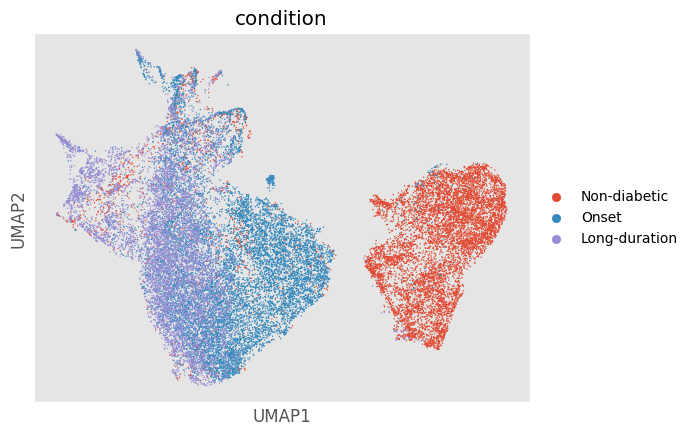

In [274]:
IsletAnalysis.plot_UMAP(color_by = 'condition')

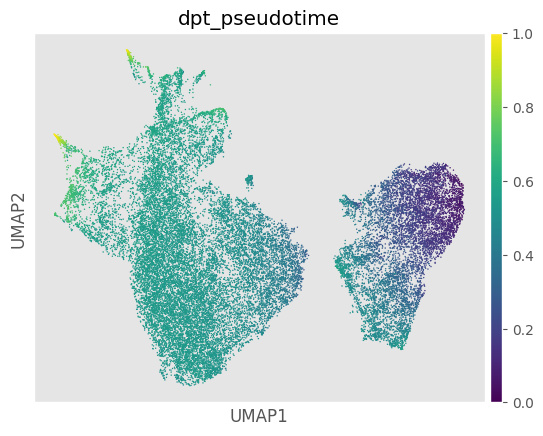

In [275]:
IsletAnalysis.plot_UMAP(color_by = 'dpt_pseudotime')

In [304]:
IsletAnalysis = palmettobug.Analysis()
IsletAnalysis.load_data(directory + f"/Analyses/islet_analysis/main", arcsinh_cofactor = 5)
IsletAnalysis.do_scaling()

for_state_plot = pd.DataFrame(IsletAnalysis.data.X, columns = list(IsletAnalysis.data.var.index)).loc[:,(IsletAnalysis.data.var['marker_class'] == 'type')]
for_state_plot['condition'] = list(IsletAnalysis.data.obs['condition'])
for_state_plot = for_state_plot.melt('condition')

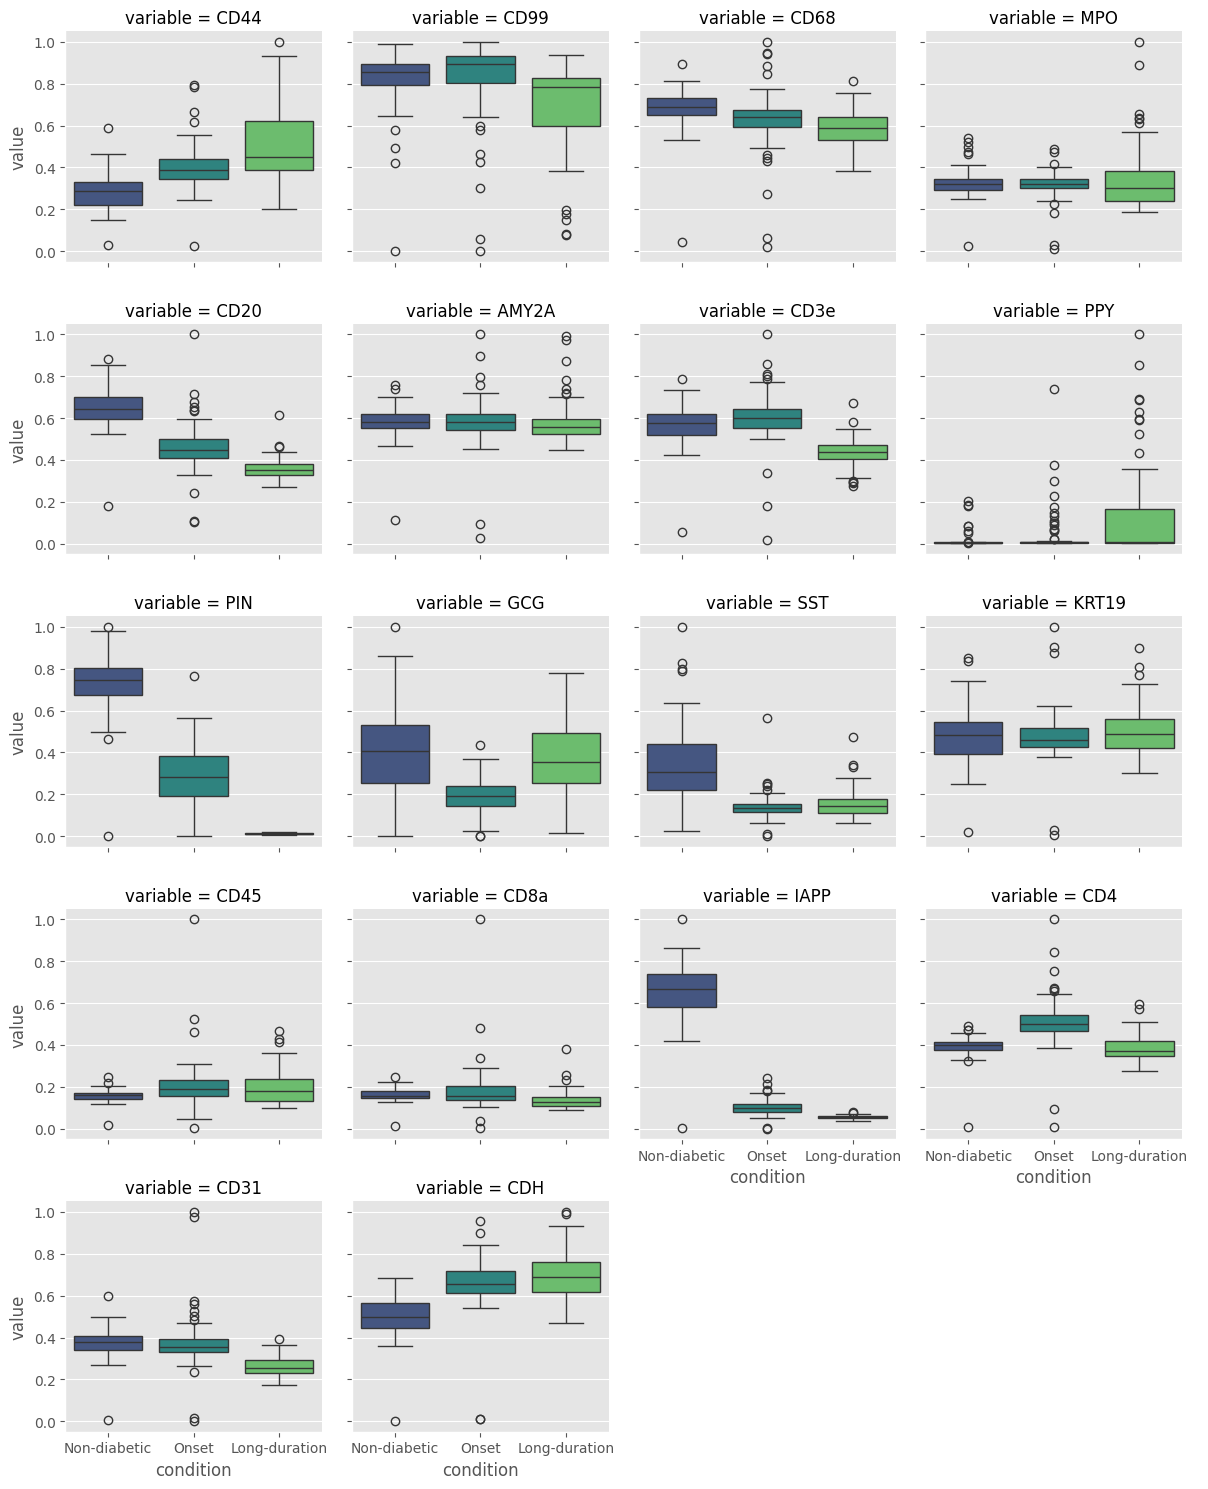

In [305]:
Grid = sns.FacetGrid(for_state_plot, col = 'variable', col_wrap = 4)
Grid.map_dataframe(sns.boxplot, x = 'condition', y = 'value', hue = 'condition', palette = 'viridis')
Grid.add_legend()
plt.show()

In [99]:
# IsletAnalysis.do_scaling('unscale')    ###### NOTE! This is on the quantile scaled values! Uncomment this line to test with the unscaled (but arcsinh transformed) data
state_expressions = IsletAnalysis.do_state_exprs_ANOVAs(marker_class = "type", groupby_column = 'whole dataset', variable = 'condition', statistic = 'mean')
state_expressions        

,antigen,whole dataset,p_value,p_adj,F statistic,avg Non-diabetic mean exprs,Non-diabetic avg stdev,avg Onset mean exprs,Onset avg stdev,avg Long-duration mean exprs,Long-duration avg stdev
12,IAPP,whole dataset,4.986000e-74,6.000000e-25,1526.00000,0.66660,0.08309,0.1016,0.02575,0.05707,0.006893
15,PIN,whole dataset,6.588000e-61,6.000000e-25,796.00000,0.74000,0.08873,0.2748,0.09683,0.01273,0.001868
1,CD20,whole dataset,7.371000e-36,6.000000e-25,208.60000,0.64840,0.07031,0.4589,0.06602,0.35340,0.038700
17,SST,whole dataset,1.018000e-20,4.581000e-20,76.80000,0.34160,0.10640,0.1426,0.03995,0.15390,0.057690
3,CD3e,whole dataset,1.476000e-17,5.314000e-17,59.34000,0.57260,0.06679,0.6044,0.07674,0.44140,0.048950
4,CD4,whole dataset,4.695000e-15,1.409000e-14,47.26000,0.39880,0.03559,0.5078,0.08262,0.37680,0.048260
10,CDH,whole dataset,4.808000e-14,1.236000e-13,42.77000,0.50690,0.07829,0.6634,0.07626,0.67700,0.093920
5,CD44,whole dataset,9.039000e-12,2.034000e-11,33.43000,0.29040,0.08170,0.4064,0.05878,0.49490,0.145300
2,CD31,whole dataset,8.487000e-11,1.697000e-10,29.73000,0.37550,0.04397,0.3808,0.09880,0.27020,0.040240
11,GCG,whole dataset,3.911000e-10,7.040000e-10,27.31000,0.40870,0.16070,0.2047,0.05848,0.36850,0.115100
